### <font color = "#44A8E3"> Inputs </font>

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import scipy.stats as st
import math
from collections import Counter
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import des listes de montants
loyers_liste = pd.read_csv("Data/loyers_liste.csv", sep=";")
loyers_france = loyers_liste.iloc[:,0].to_list()
loyers_paris= loyers_liste.iloc[:,1].to_list()
loyers_lyon= loyers_liste.iloc[:,2].to_list()

In [3]:
# Définition des inputs
clusters_dict = {"France" : {"Probas" : [0.03, True, 0.1, 0.95], "Loyers" : loyers_france}}
clusters_dict_init = copy.deepcopy(clusters_dict)

In [4]:
# Définition des paramètres de simulation
sim_n_max = 20
sim_n_min = 5
sim_step = 1
conf_level_perte = 0.95
perte_semi_interval = 0.05

### <font color = "#44A8E3"> Fonctions </font>

In [5]:
#Fonction qui calcule le nombre de ligne à générer (cas ou Bool = True)
def nl(pd, p_cer, l_int):
    n = (st.norm.ppf(p_cer)**2 * (1 - pd)) * 100 / l_int
    return math.ceil(n)

In [6]:
#Fonction qui calcule la proba max probable (cas ou Bool = False)
def pd_max(pd, p_cer, n):
    pd_new = pd + st.norm.ppf(p_cer) * (pd * (1 - pd)) / math.sqrt(n)
    return pd_new

In [7]:
#Fonction qui permet l'ajout de nb selon freq des modalités
def add_nb(n_cible, n, rows):
    n_row_mult = math.ceil(n_cible / n - 1) + 1
    rows = list(np.round(rows,0))
    Freq = Counter(rows)
    new_rows = []
    for nb, freq in Freq.items():
        new_rows.append([nb] * freq * n_row_mult)
    new_rows = sum(new_rows, [])
    return new_rows

### <font color = "#44A8E3"> Retraitements des clusters </font>

In [8]:
for cluster in clusters_dict :
    probas = clusters_dict[cluster]["Probas"]
    loyers = clusters_dict[cluster]["Loyers"]
    # On vérifie la valeur du booléen indiquant si la proba est ciblée 
    # Si booleen vrai, on calcule le nb de ligne :
    if probas[1] == True :
        probas = probas[0:4]
        probas.append(nl(probas[0], probas[3], probas[2]))
        
    # Si booleen faux, alors on a le nb de ligne et on calcule la proba de défaut max probable    
    else :
        probas[0] = pd_max(probas[0], probas[3], probas[4])
        
    # Nombre de lignes à retenir
    n_loyers = len(loyers)
    n = max(n_loyers, probas[4])

    # si nombre de lignes à retenir > nombre de loyers, il faut en ajouter
    if n > n_loyers :
        new_loyers = add_nb(n, n_loyers, loyers)
        clusters_dict[cluster]["Loyers"] = {}
        clusters_dict[cluster]["Loyers"]["liste_loyers"] = new_loyers
        clusters_dict[cluster]["Loyers"]["somme_loyers"] = sum(new_loyers)
    else :
        clusters_dict[cluster]["Loyers"] = {}
        clusters_dict[cluster]["Loyers"]["liste_loyers"] = loyers
        clusters_dict[cluster]["Loyers"]["somme_loyers"] = sum(loyers)
        
    # On crée une clé pour stocker les pertes totales futures    
    clusters_dict[cluster]["Pertes_totales"] = {}
    
    # On crée une clé pour stocker les primes futures    
    clusters_dict[cluster]["Primes"] = {}
    

### <font color = "#44A8E3"> Simulations </font>

In [9]:
# On calcule la simulation médiane
med_sim = int(np.median(list(range(sim_n_min, sim_n_max+1))))
# On crée un dictionnaire pour stocker info simulation
simulations = {}
for i in range(sim_n_min, sim_n_max+1, sim_step): 
    simulations[str(i)] = {}
    simulations[str(i)]["Pertes_totales"] = {"montant" : 0, "pct" : 0}

In [10]:
#start = time.time()
liste_pertes = []
# Pour chaque simulations n et pour chaque cluster, on va générer n pertes totales
for upper_sim in range(sim_n_min, sim_n_max+1, sim_step): 
    for sim in range(1, upper_sim + 1, sim_step):
        for cluster in clusters_dict :
            if str(upper_sim) not in clusters_dict[cluster]["Pertes_totales"]:
                clusters_dict[cluster]["Pertes_totales"][str(upper_sim)] = {}
                clusters_dict[cluster]["Pertes_totales"][str(upper_sim)]["montant"] = []
                clusters_dict[cluster]["Pertes_totales"][str(upper_sim)]["pct"] = []
            
            
            cl = clusters_dict[cluster]
            #On crée un DF ou on stocke les loyers et la proba de défaut associée
            df_probas_loyers = pd.DataFrame({"Loyers": cl["Loyers"]["liste_loyers"], "Probas" : [st.bernoulli.rvs(cl["Probas"][0]) for k in range(len(cl["Loyers"]["liste_loyers"]))]})
            # On somme les pertes du DF
            perte_totale = sum(df_probas_loyers[["Loyers","Probas"]].prod(1))
            perte_totale_pct = round(perte_totale / cl["Loyers"]["somme_loyers"],4)
            # On garde en mémoire toutes les pertes totales associée à notre simulation (upper_sim)
            cl["Pertes_totales"][str(upper_sim)]["montant"].append(perte_totale)
            cl["Pertes_totales"][str(upper_sim)]["pct"].append(perte_totale_pct)
            liste_pertes.append(perte_totale_pct)
    

#print(time.time() - start)

In [11]:
# On calcule la moyenne des pertes totales pour chaque simulations et clusters,  ainsi que les primes pour chaque cluster
for sim in range(sim_n_min, sim_n_max+1, sim_step):
    for cluster in clusters_dict :
        #Ici on calcule les moyennes des pertes totales simulées à l'étape précédentes
        cl = clusters_dict[cluster]
        cl["Pertes_totales"][str(sim)]["montant"] = np.mean(cl["Pertes_totales"][str(sim)]["montant"])
        cl["Pertes_totales"][str(sim)]["pct"] = round(np.mean(cl["Pertes_totales"][str(sim)]["pct"]),4)

        #Ici on calcule les primes de chaque cluster quand on arrive a med_sim
        if sim == med_sim :
            val_perte_pct = [cl["Pertes_totales"][str(k)]["pct"] for k in range(sim_n_min, sim + 1, sim_step)]
            mean_perte_pct = np.mean(val_perte_pct)
            var_perte_pct = np.var(val_perte_pct)
            #nombre de loyers du cluster
            n_loyers = len(clusters_dict[cluster]["Loyers"]["liste_loyers"])
            cl["Primes"] = round((mean_perte_pct + st.norm.ppf(perte_semi_interval) * np.sqrt(var_perte_pct) / np.sqrt(n_loyers)),4)
            
    # Pour chaque simulation, on somme les pertes de l'ensemble des clusters
    pertes_totales_cluster = [clusters_dict[cluster]["Pertes_totales"][str(sim)]["montant"] for cluster in clusters_dict]
    loyers_totals_cluster = [clusters_dict[cluster]["Loyers"]["somme_loyers"] for cluster in clusters_dict]
    simulations[str(sim)]["Pertes_totales"]["montant"] = sum(pertes_totales_cluster)
    simulations[str(sim)]["Pertes_totales"]["pct"] = sum(pertes_totales_cluster) / sum(loyers_totals_cluster)
    
    #Ici on calcule la prime tous clusters confondus quand on arrive a med_sim
    if sim == med_sim :
        val_perte_pct = [simulations[str(k)]["Pertes_totales"]["pct"] for k in range(sim_n_min, sim + 1, sim_step)]
        mean_perte_pct = np.mean(val_perte_pct)
        var_perte_pct = np.var(val_perte_pct)
        #nombre de loyers tous clusters confondus
        n_loyers_tot = sum([len(clusters_dict[cluster]["Loyers"]["liste_loyers"]) for cluster in clusters_dict])
        Prime_totale = round(mean_perte_pct + st.norm.ppf(perte_semi_interval) * np.sqrt(var_perte_pct) / np.sqrt(n_loyers_tot),4)


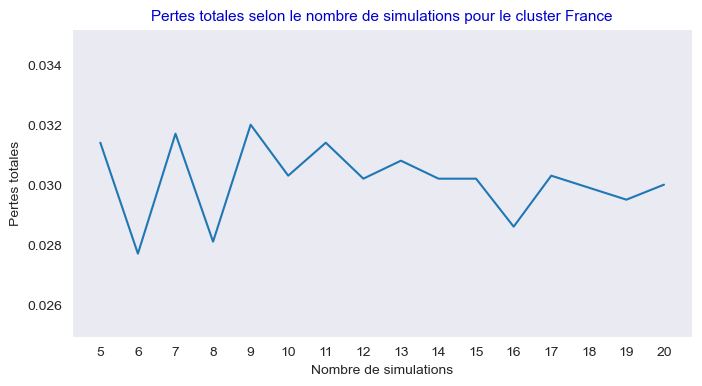

In [12]:
# Construction des graph représentant les pertes totales selon le nombre de simulations pour chaque cluster
sns.set_style("dark")
plots_cluster = {}
for cluster in clusters_dict :
    cl = clusters_dict[cluster]["Pertes_totales"] 
    x = list(cl.keys())
    y = [cl[i]["pct"] for i in x]
    min_perte = min(y)
    max_perte = max(y)
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    ax.set_title(F"Pertes totales selon le nombre de simulations pour le cluster {cluster}", fontdict={'fontsize': 11,'color': "mediumblue"})
    ax.set_xlabel("Nombre de simulations")
    ax.set_ylabel("Pertes totales")
    ax.set_ylim(min_perte * 0.9, max_perte * 1.1)
    sns.lineplot(ax=ax, x = x, y = y)
    plots_cluster[cluster] = {}
    plots_cluster[cluster]["Plot"] = fig
    plots_cluster[cluster]["Prime"] = clusters_dict[cluster]["Primes"] 
    

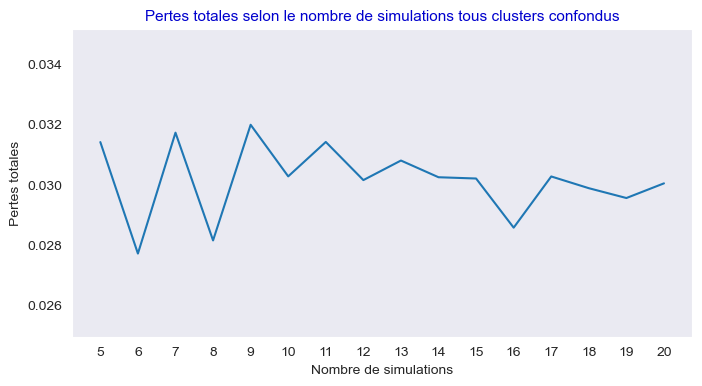

In [13]:
# Construction du graph représenant les pertes totales selon le nombre de simulations tous cluster confondus
sns.set_style("dark")
x = list(simulations.keys())
y = [simulations[str(i)]["Pertes_totales"]["pct"] for i in x]
min_perte = min(y)
max_perte = max(y)
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.set_title(F"Pertes totales selon le nombre de simulations tous clusters confondus", fontdict={'fontsize': 11,'color': "mediumblue"})
ax.set_xlabel("Nombre de simulations")
ax.set_ylabel("Pertes totales")
ax.set_ylim(min_perte * 0.9, max_perte * 1.1)
sns.set_style("dark")
sns.lineplot(ax=ax, x = x, y = y);


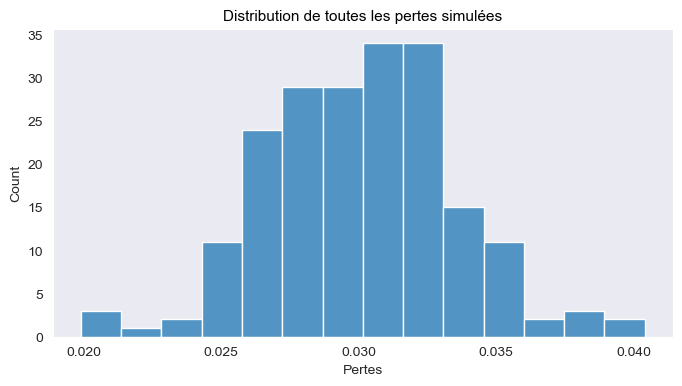

In [14]:
# Distribution de l'ensemble des pertes 
sns.set_style("dark")
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.set_title("Distribution de toutes les pertes simulées", fontdict={'fontsize': 11,'color': "black"})
ax.set_xlabel("Pertes")
sns.histplot(x=liste_pertes, stat="count");